In [2]:
import numpy as np
import subtractr
import matplotlib.pyplot as plt
import pickle
import jax
import jax.numpy as jnp

# jax enable 64 bit mode
jax.config.update("jax_enable_x64", True)

In [23]:
from subtractr.photocurrent_sim import sample_jittered_photocurrent_shapes

def add_photocurrents_to_expt(key, expt, pc_shape_params=None,
        frac_pc_cells=0.05, opsin_mean=0.3, opsin_std=0.2,
        stim_dur_ms=5.0, pc_response_var=0.01, pc_window_len_ms=200,
        sampling_freq=20000, stim_freq=30,
        prior_context=100, response_length=900, jitter=False):
    """Add photocurrents to a continuous experiment generated by circuitmap"""

    # calculate the length of the window in samples
    window_len_samples = int(pc_window_len_ms * sampling_freq / 1000)
    assert window_len_samples >= response_length, "Window length must be longer than response length."

    # Draw opsin expression from zero-inflated gamma.
    # The vector opsin_expression determines the _average_ amplitude
    # of an evoked photocurrent when stimulating that cell
    N, K = expt['stim_matrix'].shape
    pc_cells = np.random.choice(N, int(frac_pc_cells*N), replace=False)
    opsin_expression = np.zeros(N)
    opsin_expression[pc_cells] = np.random.gamma(shape=(opsin_mean/opsin_std)**2, scale=opsin_std**2/opsin_mean, size=len(pc_cells))
        
    # Draw actual evoked photocurrent heights centered around their average
    pc_contributions = pc_response_var * (
            np.random.randn(N, K) * (opsin_expression[:, None] > 0)) + opsin_expression[:,None]

    if pc_shape_params is None:
        pc_shape_params = dict(
            O_inf_min=0.3,
                O_inf_max=1.0,
                R_inf_min=0.1,
                R_inf_max=1.0,
                tau_o_min=6,
                tau_o_max=8,
                tau_r_min=5,
                tau_r_max=8, 
            )

    pc_full_params = dict(
        onset_jitter_ms=0.01,
        onset_latency_ms=0.0,
        pc_shape_params=pc_shape_params,
        add_target_gp=False,
        target_gp_lengthscale=20,
        target_gp_scale=0.01,
        linear_onset_frac=1.0,
        msecs_per_sample=0.05,
        stim_start=0.0,
        stim_end=stim_dur_ms,
        isi_ms=30,
        window_len_ms=pc_window_len_ms,
    )
   
    # Get a PC shape for every stim
    stim_mat_scaled = expt['stim_matrix'] / np.max(expt['stim_matrix'])

    # Sample photocurrent shapes. optionally add jitter
    if jitter:
        jittered_pc_shapes = np.array(sample_jittered_photocurrent_shapes(key, K, **pc_full_params)[1])
    else:
        jittered_pc_shapes = np.array(sample_jittered_photocurrent_shapes(key, 1, **pc_full_params)[1])
        jittered_pc_shapes = np.broadcast_to(jittered_pc_shapes, (K, jittered_pc_shapes.shape[1]))
    true_photocurrents = np.sum(stim_mat_scaled * pc_contributions, axis=0)[:,None] * jittered_pc_shapes
    
    # Add photocurrents to unrolled trace to capture inter-trial overlap
    obs_flat = unfold_to_flat(expt['obs_responses'],
                    response_length=response_length, prior_context=prior_context,
                        stim_freq=stim_freq, sampling_freq=sampling_freq)
    expt['flat_ground_truth'] = obs_flat.copy()
    
    isi = int(sampling_freq / stim_freq)
    stim_times = np.arange(0, K * isi, isi) + prior_context

    for i,stim_idx in enumerate(stim_times):
        _end_idx = stim_idx + window_len_samples
        end_idx_flat = np.minimum(_end_idx, len(obs_flat))
        end_idx_wrapped = jittered_pc_shapes.shape[1] - np.maximum(_end_idx - len(obs_flat), 0)
        
        if end_idx_flat <= stim_idx:
            import pdb; pdb.set_trace()
            
        obs_flat[stim_idx:end_idx_flat] += true_photocurrents[i,:end_idx_wrapped]
       
    expt['obs_with_photocurrents'] = fold_overlapping(obs_flat, prior_context, response_length,
                                                         sampling_freq, stim_freq,)
    expt['true_photocurrents'] = true_photocurrents
    expt['opsin_expression'] = opsin_expression
    return expt

def fold_overlapping(trace, prior_context, response_length, sampling_freq, stim_freq):
    """
    Split trace into overlapping segments of length response_length.
    prior_context determines the amount which is overlapped from the prior trial
    """
    num_samples = trace.shape[0]
    isi = int(sampling_freq / stim_freq)
    start_indices = np.arange(0, num_samples - response_length + prior_context, isi)

    end_indices = start_indices + response_length
    return np.array([trace[x:y] for x,y in zip(start_indices, end_indices)])

def unfold_to_flat(traces, response_length=900, prior_context=100, stim_freq=30, sampling_freq=20000):
    response_length = traces.shape[1]
    
    next_stim_idx = prior_context + int(sampling_freq / stim_freq)
    next_stim_idx = np.minimum(next_stim_idx, response_length-1)
    
        
    # include prior context on first trace, after that we leave it off
    flattened = np.concatenate(traces[:, prior_context:next_stim_idx])
    flattened = np.concatenate((traces[0, 0:prior_context], flattened, traces[-1,next_stim_idx:]))
    
    return flattened
    
    
def subtract_overlapping_trials(orig, est,
            prior_context=100, stim_freq=30,
            sampling_freq=20000, return_flat=False):
    
    
    # compute stim times based on prior context and response length
    num_stims, response_length = orig.shape
    
    obs_flat = unfold_to_flat(orig, response_length=response_length,
                    prior_context=prior_context, stim_freq=stim_freq,
                              sampling_freq=sampling_freq)
    

    isi = int(sampling_freq / stim_freq)
    stim_times = np.arange(0, num_stims * isi, isi)
   
    num_samples = obs_flat.shape[0]
    subtracted_flat = obs_flat.copy()
    for stim_idx, pc_est in zip(stim_times, est):
        _end_idx = stim_idx + response_length
        end_idx_flat = np.minimum(_end_idx, len(obs_flat))
        end_idx_wrapped = pc_est.shape[0] - np.maximum(_end_idx - len(obs_flat), 0)
        subtracted_flat[stim_idx:end_idx_flat] -= pc_est[:end_idx_wrapped]
        
        # # check whether we're at the end of the trace
        # if end_idx > num_samples:
        #     est_cutoff = end_idx - num_samples
        #     end_idx = num_samples
        #     subtracted_flat[stim_idx:end_idx] -= pc_est[:est_cutoff] 
        # else:
        #     subtracted_flat[stim_idx:end_idx] -= pc_est

    if return_flat:
        return subtracted_flat
    return fold_overlapping(subtracted_flat, prior_context, response_length, sampling_freq, stim_freq)


In [4]:
# load saved expts dictionary
with open('expts.pkl', 'rb') as f:
    expts = pickle.load(f)

In [26]:
stim_freq = 30
expt = expts[stim_freq]

# add photocurrents to experiment
key = jax.random.PRNGKey(0)
expt = add_photocurrents_to_expt(key, expt, stim_freq=stim_freq, response_length=2000)

est = subtractr.low_rank.estimate_photocurrents_by_batches(expt['obs_with_photocurrents'],
    stim_start=100, stim_end=200, constrain_V=True, rank=1, batch_size=200, subtract_baselines=True)

subtracted_flat = subtract_overlapping_trials(expt['obs_with_photocurrents'], est,
            prior_context=100, stim_freq=stim_freq,
            return_flat=True,)

flat_with_photocurrents = unfold_to_flat(traces=expt['obs_with_photocurrents'],
    response_length=2000, prior_context=100, stim_freq=stim_freq, sampling_freq=20000)
orig_flat = expt['flat_ground_truth']

Running photocurrent estimation with 10 batches...


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


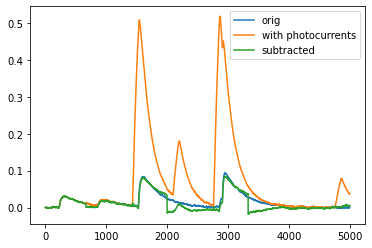

In [27]:
plt.plot(orig_flat[0:5000], label='orig')
plt.plot(flat_with_photocurrents[0:5000], label='with photocurrents')
plt.plot(subtracted_flat[0:5000], label='subtracted')
plt.legend()

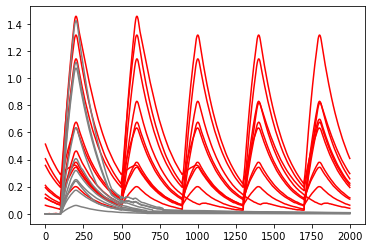

In [20]:
plt.plot(expt['obs_with_photocurrents'][0:10].T, label='obs', color='red')
plt.plot(est[0:10].T, label='est', color='grey')

plt.show()

In [10]:
np.any(np.isnan(est))

False

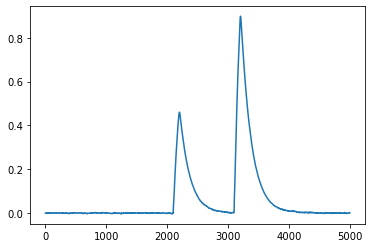

In [9]:
obs_flat = unfold_to_flat(expt['obs_with_photocurrents'], response_length=2000,
                    prior_context=100, stim_freq=stim_freq,
                            )
plt.plot(obs_flat[0:5000], label='orig')